# Problem Set 4

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sts
import scipy.optimize as opt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## Question 1

**(a)**

In [2]:
inc = pd.read_csv('data/incomes.txt', names = ['Income'])

<IPython.core.display.Javascript object>


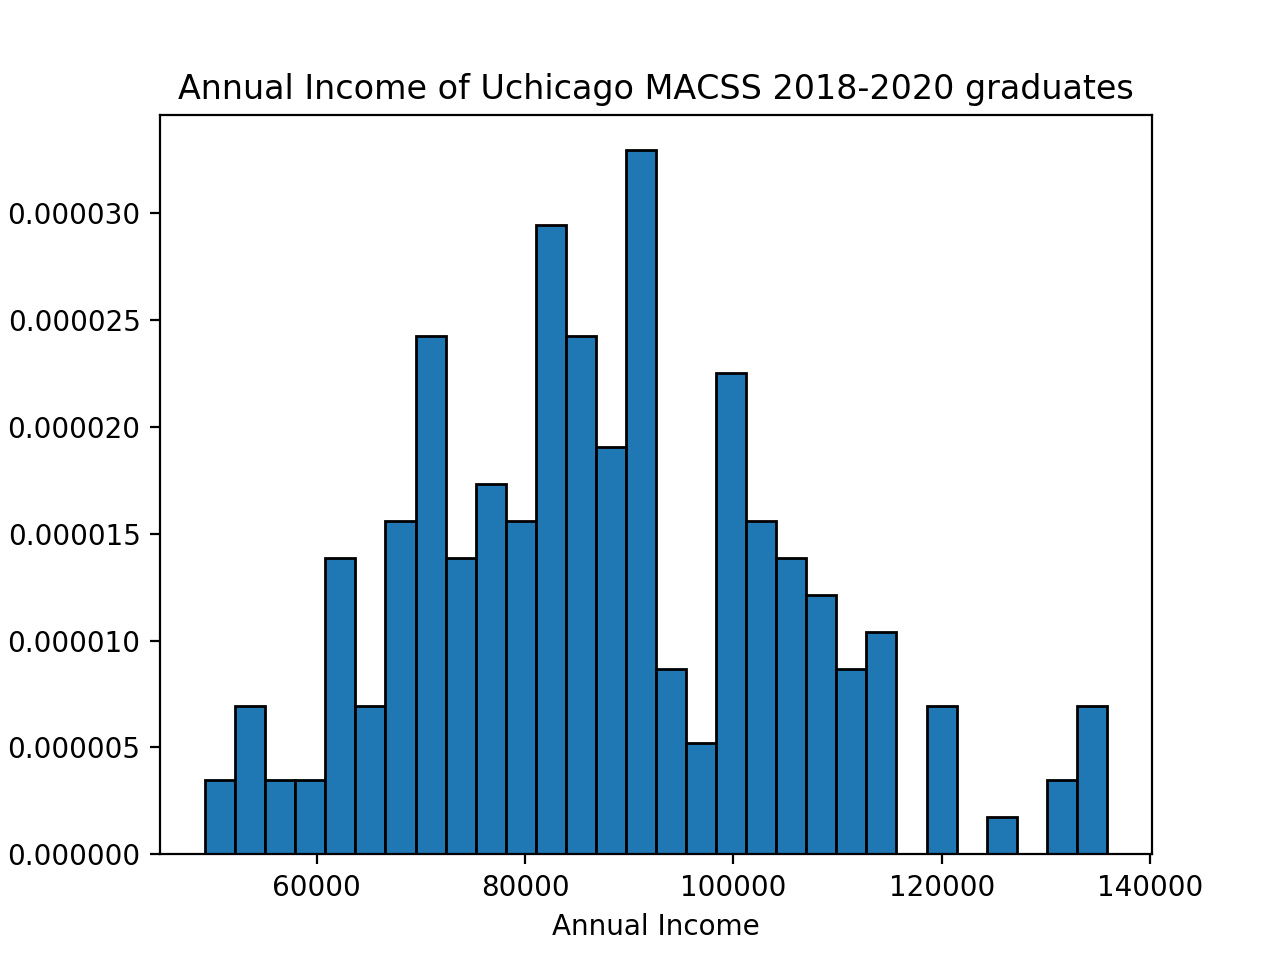

Text(0,0.5,'Percentage')

In [3]:
%matplotlib notebook
plt.hist(inc['Income'], 30, normed=True, edgecolor='k')
plt.title('Annual Income of Uchicago MACSS 2018-2020 graduates')
plt.xlabel('Annual Income')
plt.ylabel('Percentage')

**(b)**

In [6]:
# Define function that generates values of a lognormal pdf
def trunc_lognorm_pdf(xvals, mu, sigma, cut_lb, cut_ub):
    
    if cut_ub == 'None' and cut_lb == 'None':
        prob_notcut = 1.0
    elif cut_ub == 'None' and cut_lb != 'None':
        prob_notcut = 1.0 - sts.lognorm.cdf(cut_lb, sigma, scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb == 'None':
        prob_notcut = sts.lognorm.cdf(cut_ub, sigma, scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb != 'None':
        prob_notcut = (sts.lognorm.cdf(cut_ub, sigma, scale=np.exp(mu)) -
                       sts.lognorm.cdf(cut_lb, sigma, scale=np.exp(mu)))
            
    pdf_vals    = ((1/(xvals * sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvals) - mu) ** 2 / (2 * sigma ** 2))) /
                    prob_notcut)
    
    return pdf_vals

<IPython.core.display.Javascript object>


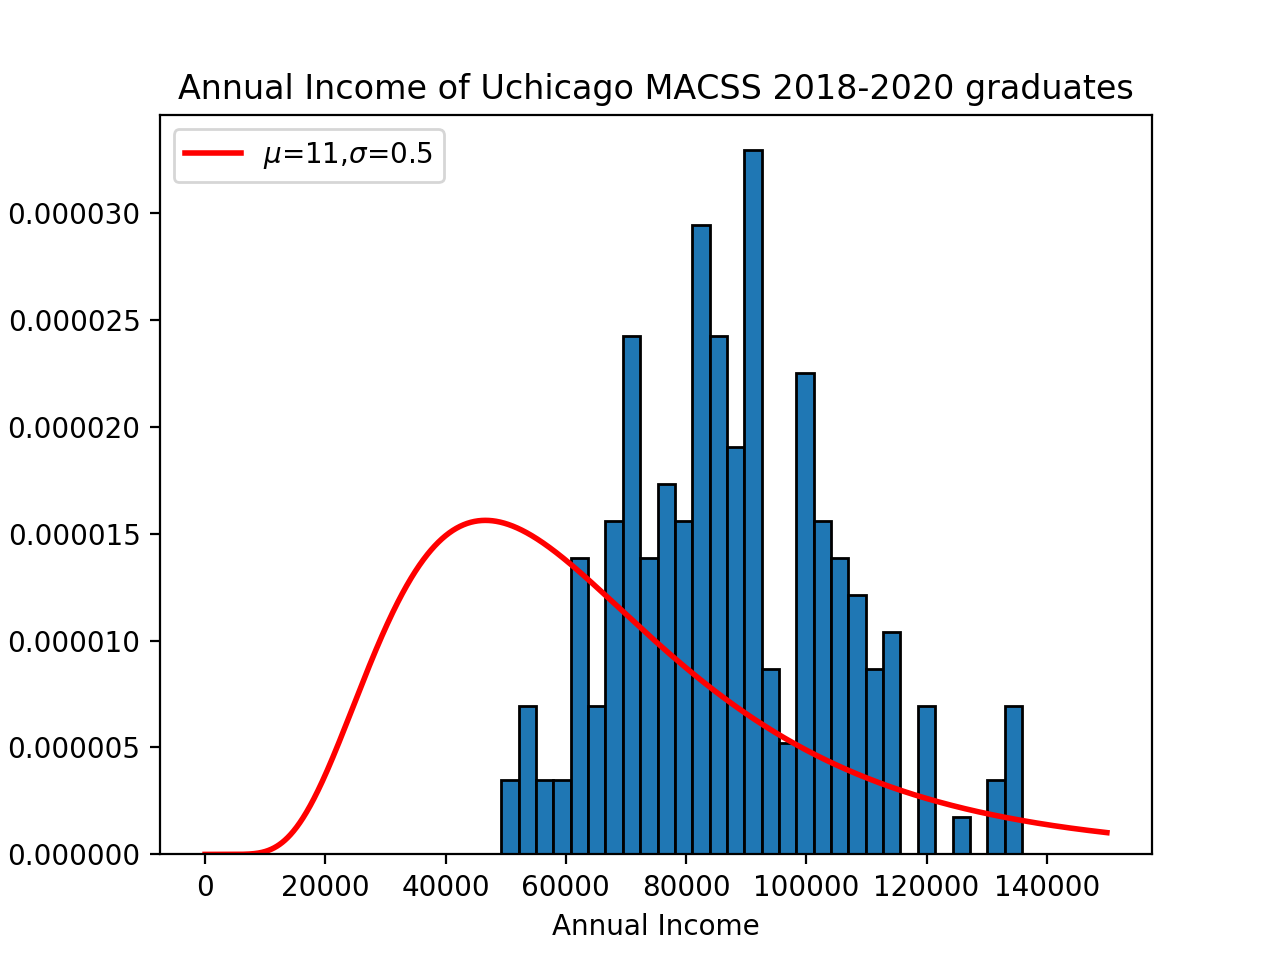

In [7]:
%matplotlib notebook
plt.hist(inc['Income'], 30, normed=True, edgecolor='k')
plt.title('Annual Income of Uchicago MACSS 2018-2020 graduates')
plt.xlabel('Annual Income')
plt.ylabel('Percentage')

dist_pts = np.linspace(1e-10, 150000, 2000)
mu_1 = 11
sig_1 = 0.5
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_1, sig_1, 0, 150000),
         linewidth=2, color='r', label='$\mu$=11,$\sigma$=0.5')
plt.legend(loc='upper left')

In [8]:
# Define log likelihood function for the normal distribution
def log_lik_truncnorm(xvals, mu, sigma, cut_lb, cut_ub):

    pdf_vals = trunc_lognorm_pdf(xvals, mu, sigma, cut_lb, cut_ub)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

print('Log-likelihood:', log_lik_truncnorm(inc['Income'], mu_1, sig_1, 0, 150000))

Log-likelihood: -2379.120591931827


**(c)**

In [12]:
def crit(params, *args):
    
    mu, sigma = params
    xvals, cut_lb, cut_ub = args
    log_lik_val = log_lik_truncnorm(xvals, mu, abs(sigma), cut_lb, cut_ub)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [13]:
params_init = np.array([mu_1, sig_1])
mle_args = (inc['Income'], 0, 150000)
results_uncstr = opt.minimize(crit, params_init, args=(mle_args))
mu_MLE, sig_MLE = results_uncstr.x
print('mu_MLE =', mu_MLE, ' sig_MLE=', sig_MLE)
print('MLE log-likelihood:', log_lik_truncnorm(inc['Income'], mu_MLE, sig_MLE, 0, 150000))

mu_MLE = 11.361699965967007  sig_MLE= 0.21174326386681536
MLE log-likelihood: -2240.934337511636


<IPython.core.display.Javascript object>


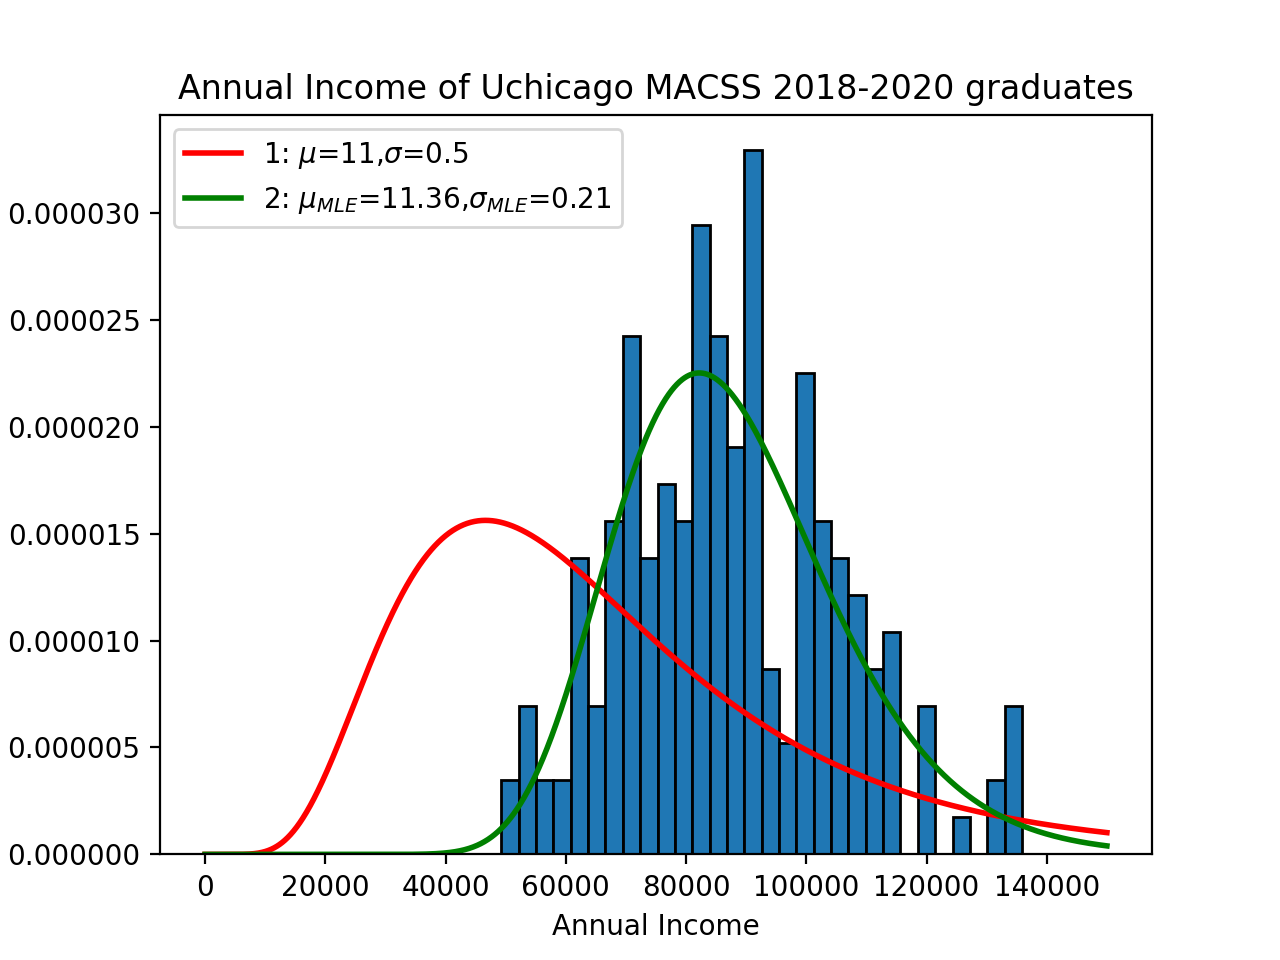

In [159]:
%matplotlib notebook
plt.hist(inc['Income'], 30, normed=True, edgecolor='k')
plt.title('Annual Income of Uchicago MACSS 2018-2020 graduates')
plt.xlabel('Annual Income')
plt.ylabel('Percentage')

plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_1, sig_1, 0, 150000),
         linewidth=2, color='r', label='1: $\mu$=11,$\sigma$=0.5')
plt.legend(loc='upper left')

plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_MLE, sig_MLE, 0, 150000),
         linewidth=2, color='g', label='2: $\mu_{MLE}$=11.36,$\sigma_{MLE}$=0.21')
plt.legend(loc='upper left')

In [160]:
vcv_mle = results_uncstr.hess_inv

stderr_mu_mle = np.sqrt(vcv_mle[0,0])
stderr_sig_mle = np.sqrt(vcv_mle[1,1])
print('VCV(MLE) = ', vcv_mle)
print('Standard error for mu estimate = ', stderr_mu_mle)
print('Standard error for sigma estimate = ', stderr_sig_mle)

VCV(MLE) =  [[ 2.05516896e-04 -1.58272274e-05]
 [-1.58272274e-05  9.92889787e-05]]
Standard error for mu estimate =  0.014335860496126812
Standard error for sigma estimate =  0.009964385515514781


In [161]:
print('mu percent', stderr_mu_mle/mu_MLE)
print('sig percent', stderr_sig_mle/sig_MLE)

mu percent 0.001261770733170973
sig percent 0.0470588076028822


**(d)**

In [162]:
log_lik_h0 = log_lik_truncnorm(inc['Income'], mu_1, sig_1, 0, 150000)
print('Hypothesis value log likelihood', log_lik_h0)
log_lik_mle = log_lik_truncnorm(inc['Income'], mu_MLE, sig_MLE, 0, 150000)
print('MLE log likelihood', log_lik_mle)
LR_val = 2 * (log_lik_mle - log_lik_h0)
print('Likelihood ratio value', LR_val)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print('Chi-squared of H0 with 2 degrees of freedom p-value = ', pval_h0)

Hypothesis value log likelihood -2379.120591931827
MLE log likelihood -2240.934337511636
Likelihood ratio value 276.3725088403826
Chi-squared of H0 with 2 degrees of freedom p-value =  0.0


**(e)**

In [17]:
p_more = 1 - sts.lognorm.cdf(100000, sig_MLE, scale=np.exp(mu_MLE))
print('The probability that I will earn more than $100,000 is', p_more)
p_less = sts.lognorm.cdf(75000, sig_MLE, scale=np.exp(mu_MLE))
print('The probability that I will earn less than $75,000 is', p_less)

The probability that I will earn more than $100,000 is 0.23755400684543593
The probability that I will earn less than $75,000 is 0.2596439369860366


# Question 2

**(a)**

In [164]:
def normal_pdf(xvals, sigma):
    mu = 0
    pdf_vals = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (xvals - mu)**2 / (2 * sigma**2))
    return pdf_vals

In [165]:
def log_lik_norm(y, x1, x2, x3, b0, b1, b2, b3, sigma):
    e = y - b0 - b1*x1 - b2*x2 - b3*x3
    pdf_vals = normal_pdf(e, sigma)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

In [166]:
def crit_err(params, *args):
    b0, b1, b2, b3, sig = params
    y, x1, x2, x3 = args
    log_lik_val = log_lik_norm(y, x1, x2, x3, b0, b1, b2, b3, sig)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [167]:
sick = pd.read_csv('data/sick.txt')
b0_init = 0
b1_init = 0
b2_init = 0
b3_init = 0
sig_init = 0.5
params_init = np.array([b0_init, b1_init, b2_init, b3_init, sig_init])
mle_args = (sick['sick'], sick['age'], sick['children'], sick['avgtemp_winter'])

In [170]:
results = opt.minimize(crit_err, params_init, args=(mle_args))
b0_MLE = results.x[0]
b1_MLE = results.x[1]
b2_MLE = results.x[2]
b3_MLE = results.x[3]
sig_MLE = results.x[4]

In [176]:
print('beta 0 is', b0_MLE)
print('beta 1 is', b1_MLE)
print('beta 2 is', b2_MLE)
print('beta 3 is', b3_MLE)
print('Sigma is', sig_MLE)
print('Value of the log likelihood function:', -results.fun)

beta 0 is 0.2516462711438202
beta 1 is 0.012933407008716338
beta 2 is 0.4005014167601437
beta 3 is -0.009991697399664753
Sigma is 0.00301763486982928
Value of the log likelihood function: 876.8650534025467


In [177]:
print('Estimated variance covariance matrix:\n', results.hess_inv)

Estimated variance covariance matrix:
 [[ 7.18963108e-07  7.15252170e-09 -1.22893544e-07 -1.68425764e-08
  -1.39318227e-08]
 [ 7.15252170e-09  2.94049395e-09 -2.56988757e-08 -1.87724723e-09
   3.69351246e-10]
 [-1.22893544e-07 -2.56988757e-08  2.63725509e-07  1.61019143e-08
   7.00109634e-11]
 [-1.68425764e-08 -1.87724723e-09  1.61019143e-08  1.48362682e-09
   4.16035022e-13]
 [-1.39318227e-08  3.69351246e-10  7.00109634e-11  4.16035021e-13
   1.97365385e-08]]


**(b)**

In [178]:
b0_null, b1_null, b2_null, b3_null, sig_null = 1, 0, 0, 0, 0.1
y, x1, x2, x3 = sick['sick'], sick['age'], sick['children'], sick['avgtemp_winter']
log_lik_h0 = log_lik_norm(y, x1, x2, x3, b0_null, b1_null, b2_null, b3_null, sig_null)
print('Hypothesis value log likelihood', log_lik_h0)
log_lik_mle = log_lik_norm(y, x1, x2, x3, b0_MLE, b1_MLE, b2_MLE, b3_MLE, sig_MLE)
print('MLE log likelihood', log_lik_mle)
LR_val = 2 * (log_lik_mle - log_lik_h0)
print('Likelihood ratio value', LR_val)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 5)
print('Chi-squared of H0 with 5 degrees of freedom p-value = ', pval_h0)

Hypothesis value log likelihood -2253.700688042125
MLE log likelihood 876.8650534025467
Likelihood ratio value 6261.131482889343
Chi-squared of H0 with 5 degrees of freedom p-value =  0.0


The p-value corresponding to the LR value is 0.0, therefore we can reject the null hypothesis that age, number of children, and average winter temperature have no effect on the number of sick days.